# Exploration Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle

In [2]:
df = wrangle.get_spotify_top_artists_discography_data()
train, validate, test = wrangle.split_data(df)
scaler, train_scaled, validate_scaled, test_scaled = wrangle.standard_scaler(train, validate, test)

### Examine distributions

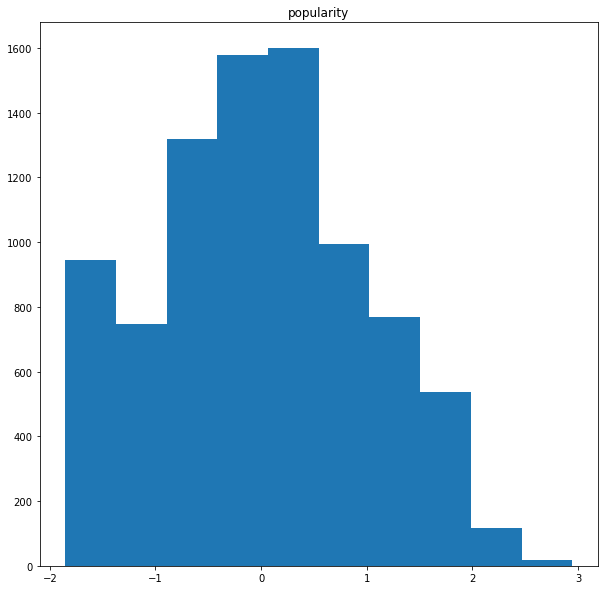

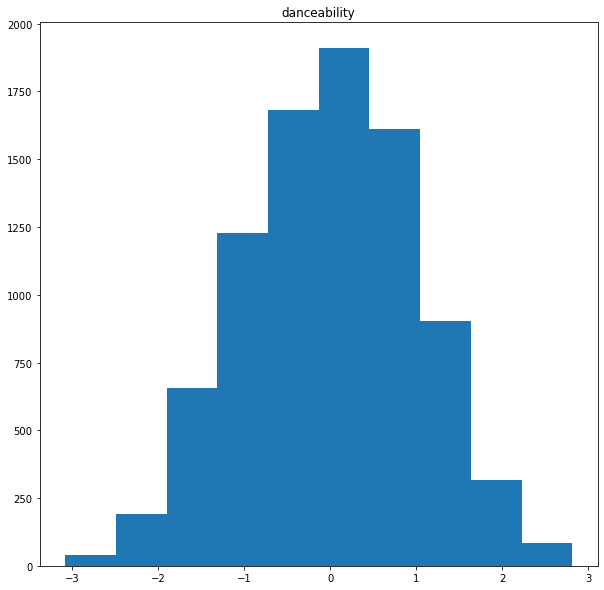

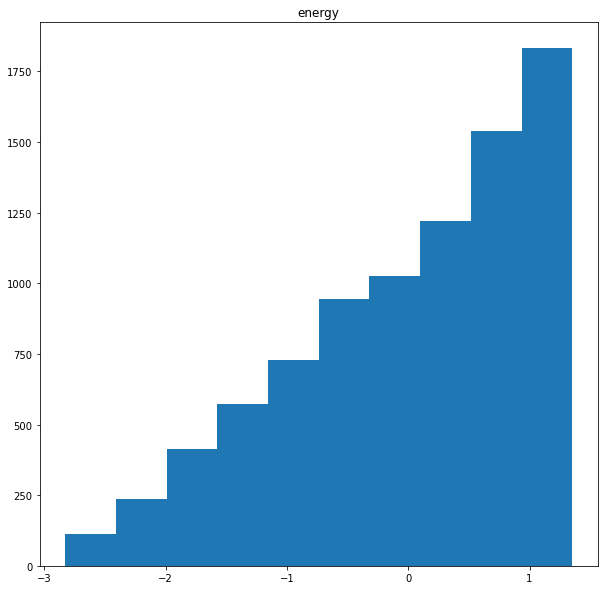

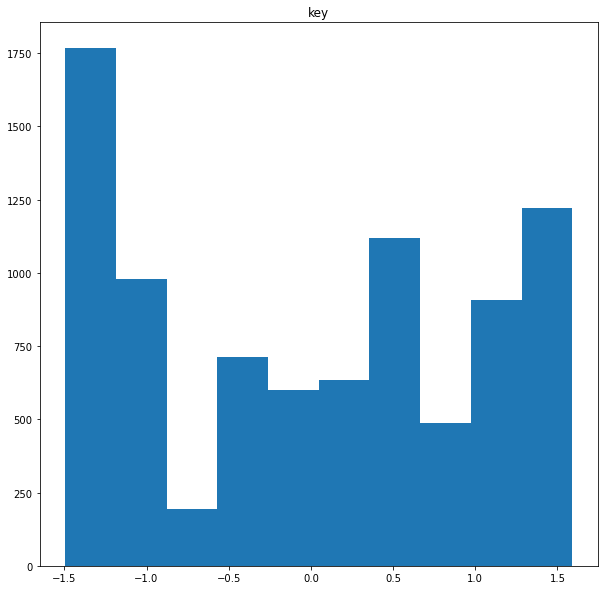

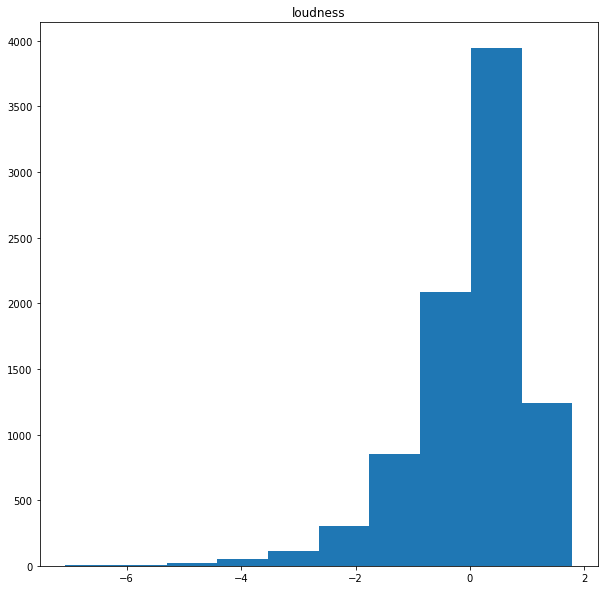

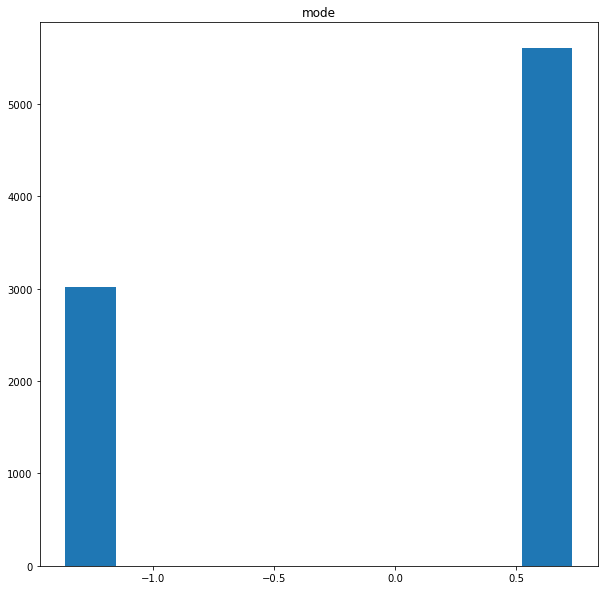

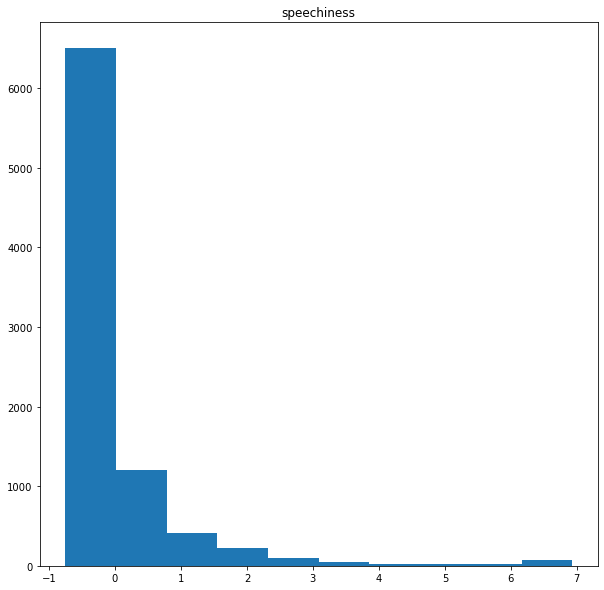

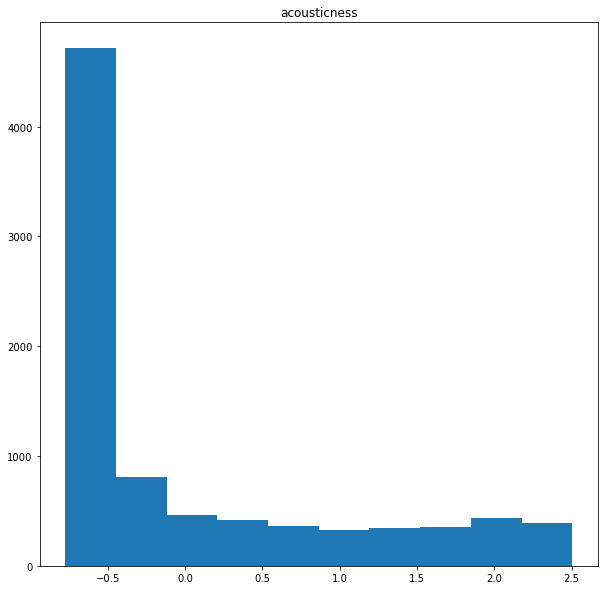

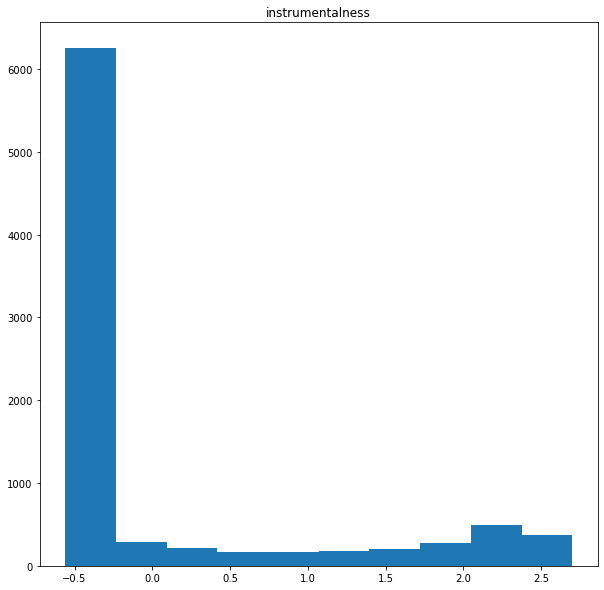

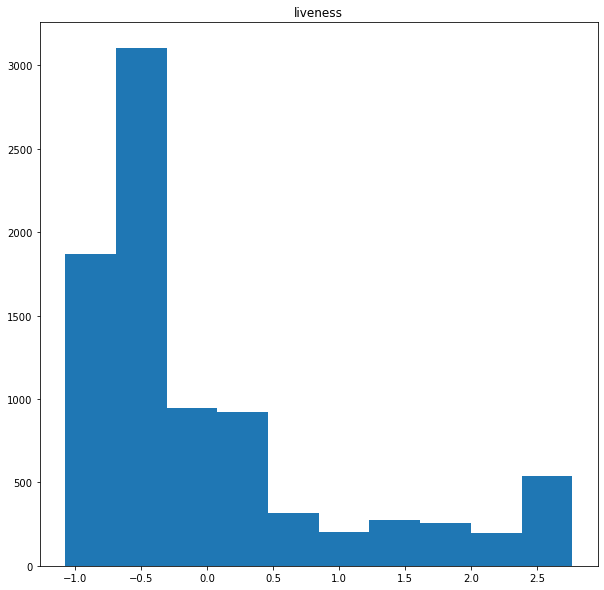

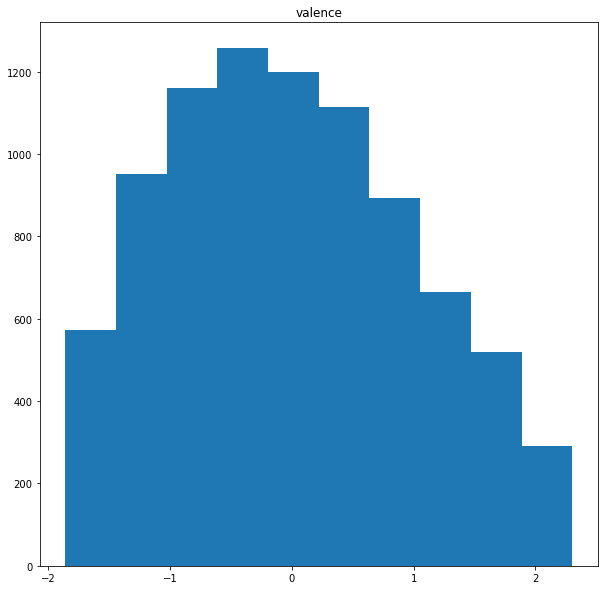

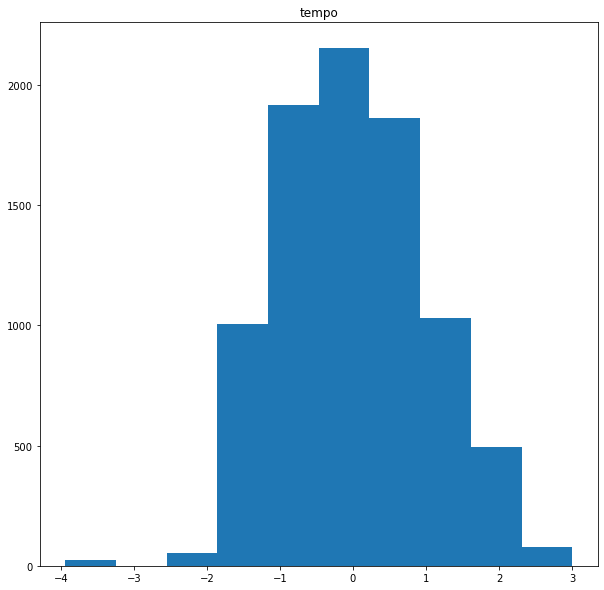

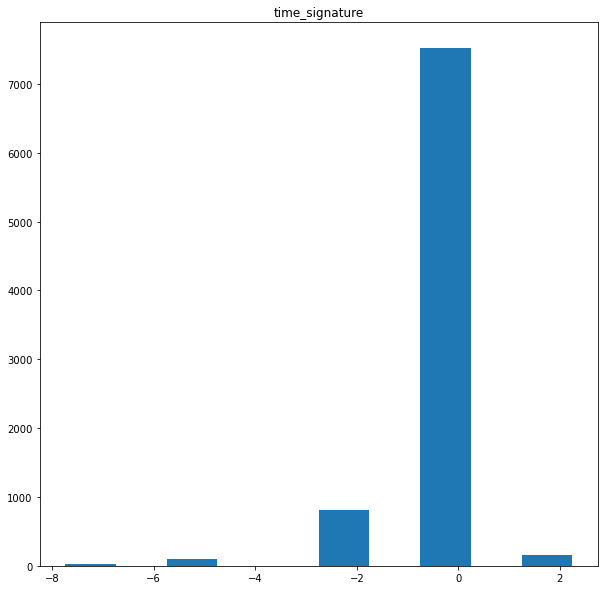

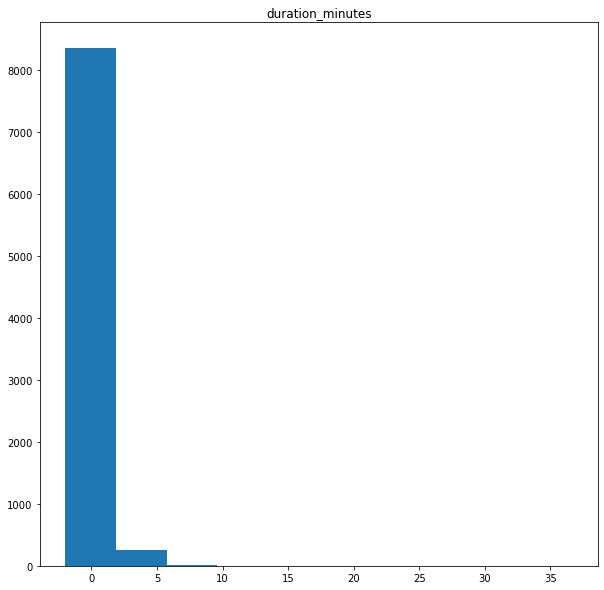

In [3]:
for col in train_scaled.columns.to_list():
    plt.figure(figsize=(10,10))
    plt.hist(train_scaled[col])
    plt.title(col)

### Check outliers

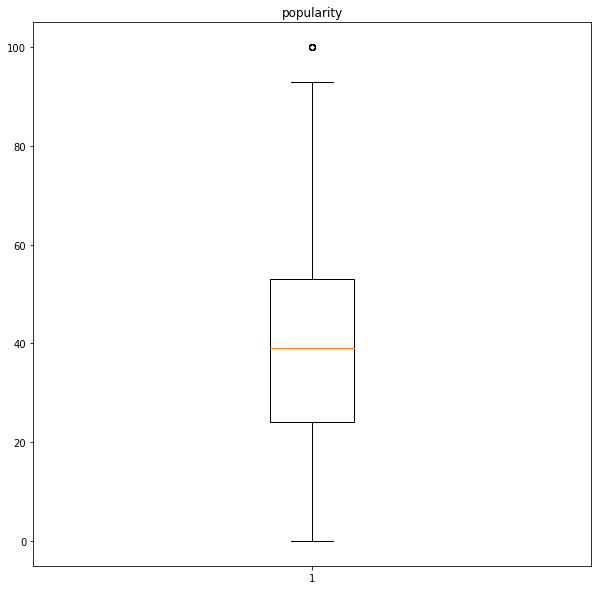

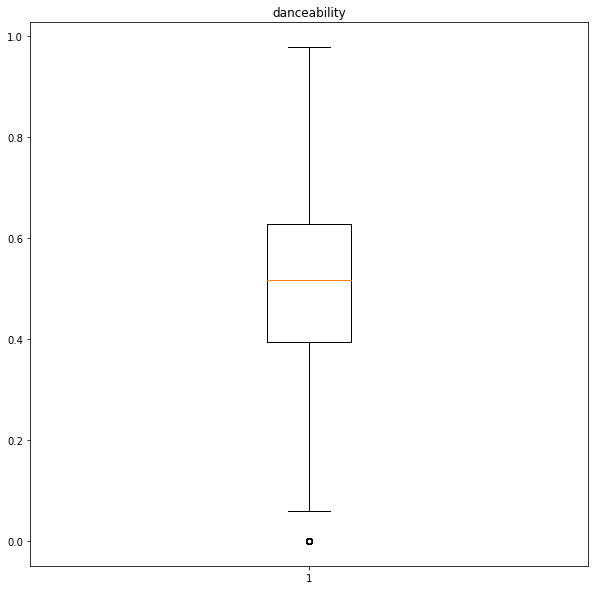

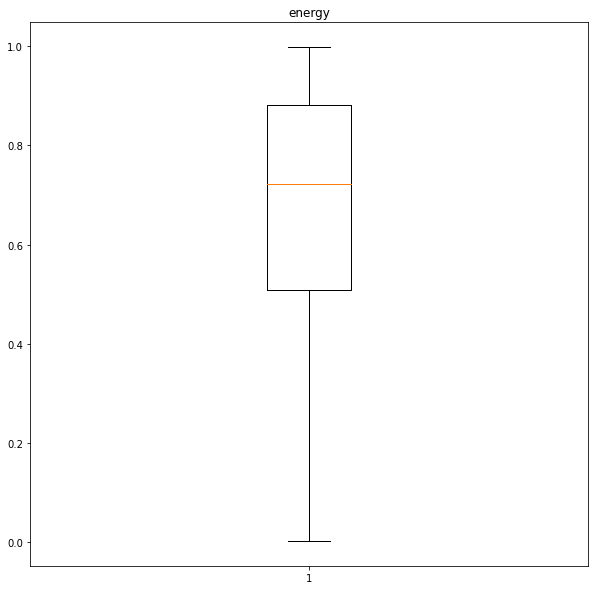

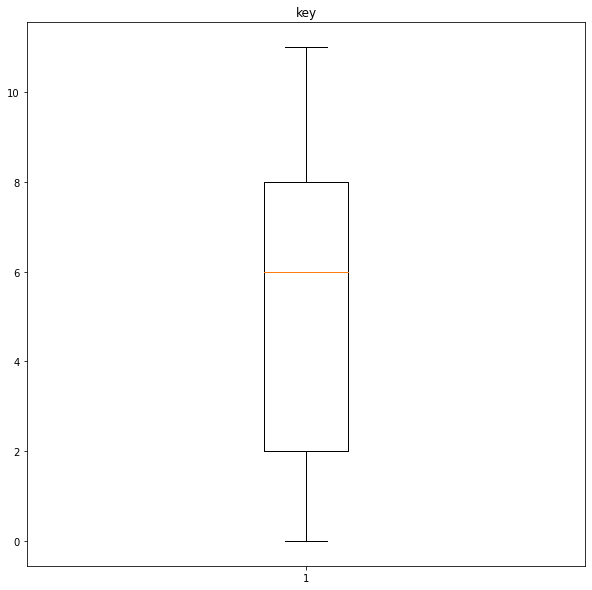

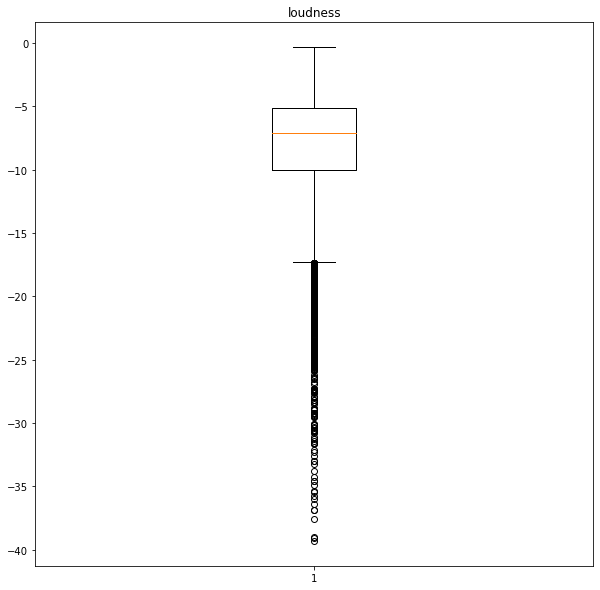

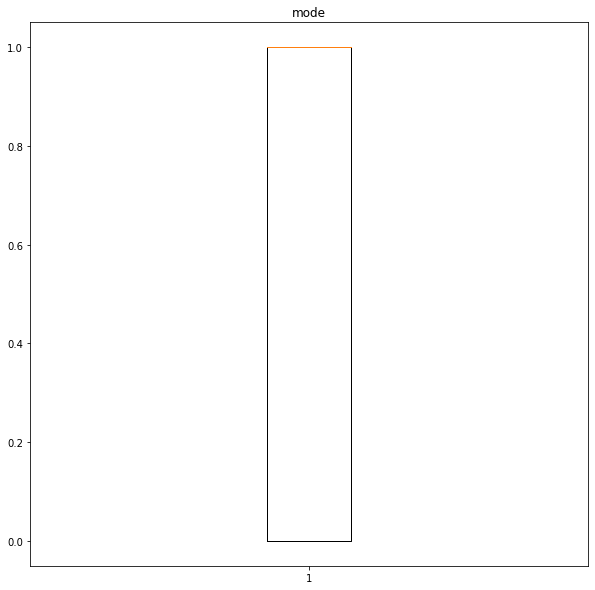

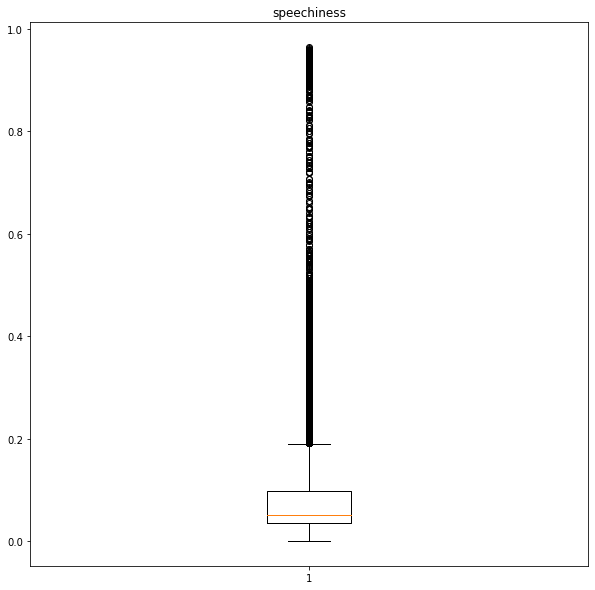

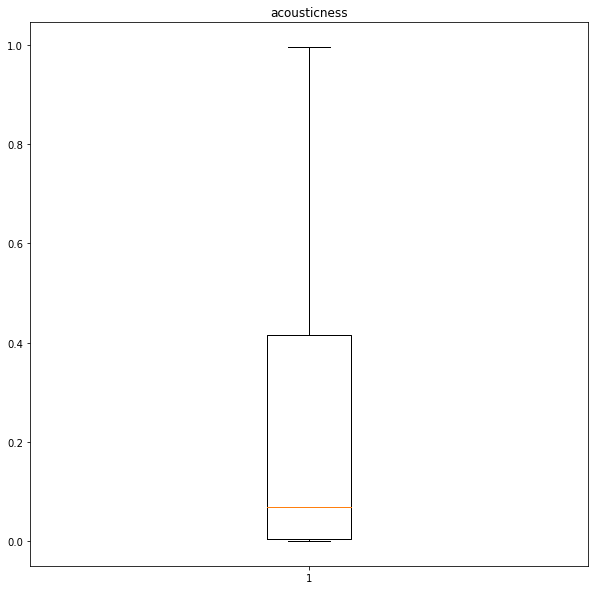

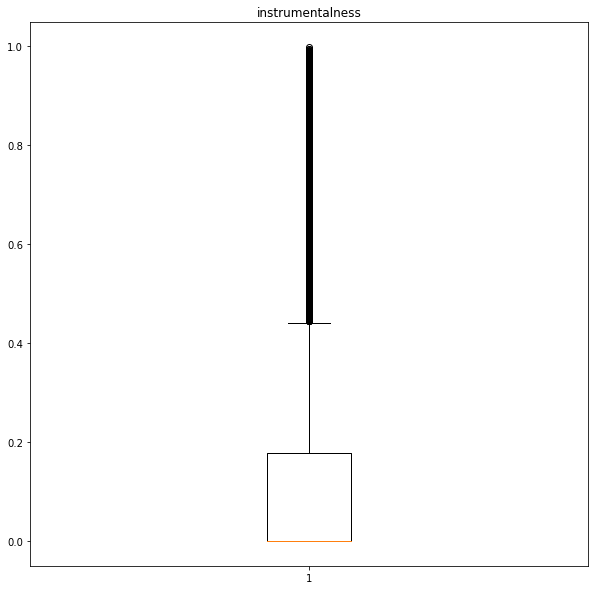

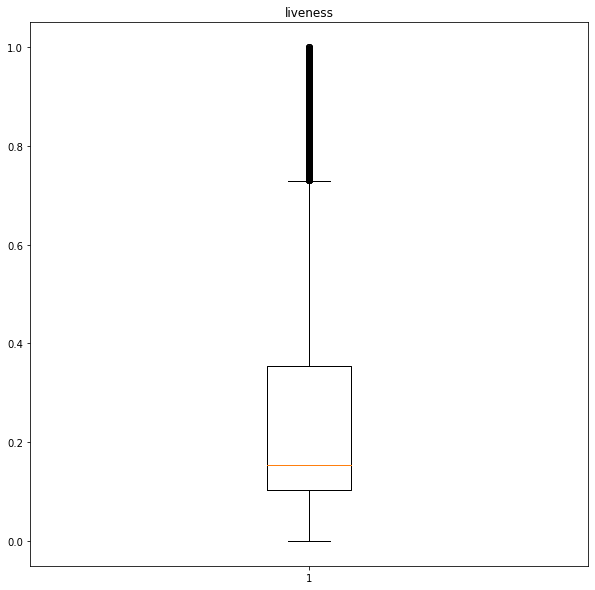

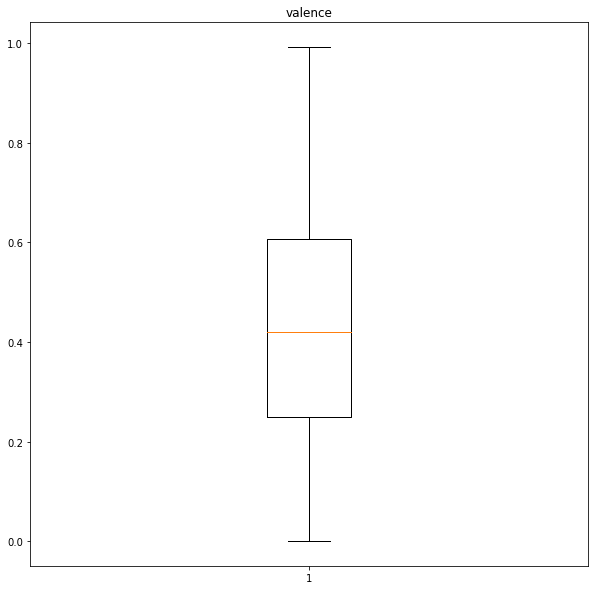

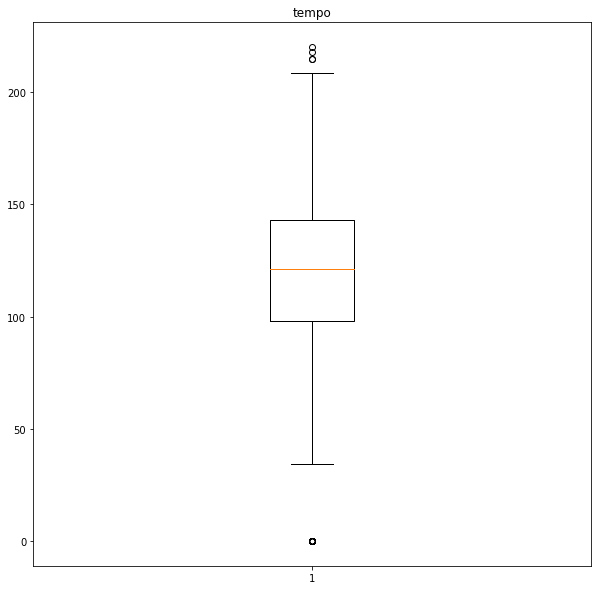

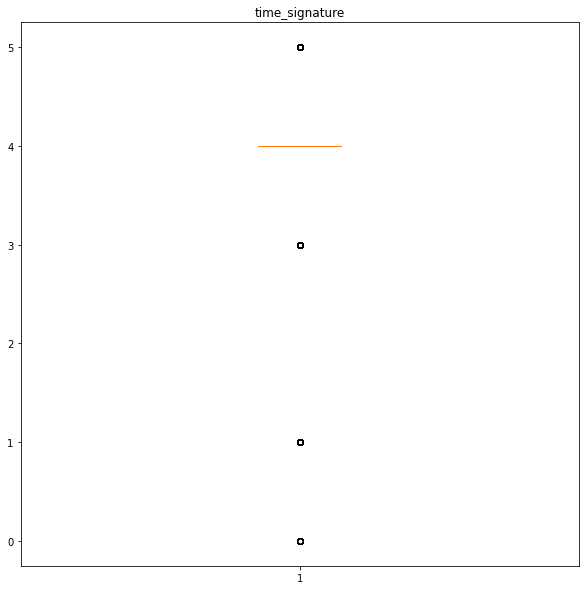

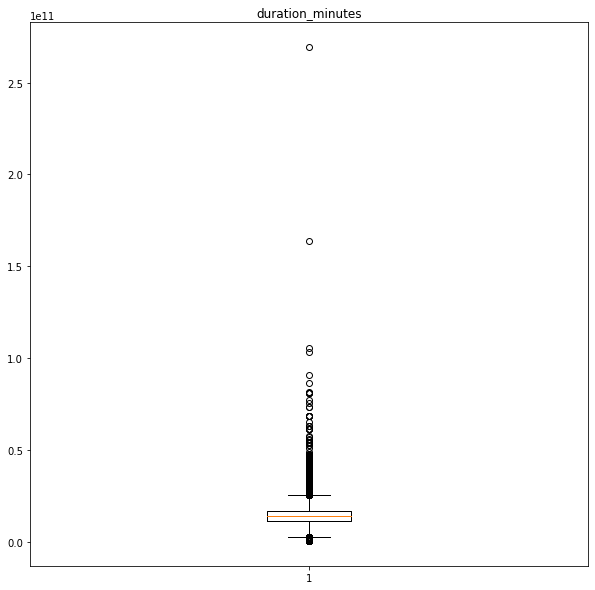

In [4]:
for col in df.drop(columns=['artist','song','album']).columns.to_list():
    plt.figure(figsize=(10,10))
    plt.boxplot(df[col])
    plt.title(col)

In [5]:
# Create X and y for train, validate, test and their scaled versions.
X_train = train.drop(columns=['artist','song','album','popularity'])
y_train = train['popularity']

X_validate = validate.drop(columns=['artist','song','album','popularity'])
y_validate = validate['popularity']

X_test = test.drop(columns=['artist','song','album','popularity'])
y_test = test['popularity']

X_train_scaled = train_scaled.drop(columns=['popularity'])
y_train_scaled = train_scaled['popularity']

X_validate_scaled = validate_scaled.drop(columns=['popularity'])
y_validate_scaled = validate_scaled['popularity']

X_test_scaled = test_scaled.drop(columns=['popularity'])
y_test_scaled = test_scaled['popularity']

In [6]:
X_train_scaled.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_minutes
14591,-1.371170,-0.923792,-1.495962,-0.374862,0.733360,-0.451836,2.020742,-0.560469,-0.576266,-0.903595,-1.245847,-5.748586,-0.061680
6360,-0.931704,-1.632450,-1.495962,-1.412247,0.733360,-0.510794,2.350116,-0.480270,-0.641596,-0.385508,-0.902136,0.246643,-0.613975
3474,0.687699,-0.391251,1.309984,0.125384,-1.363587,-0.410406,-0.429798,-0.560885,-0.633910,-0.440714,0.197056,0.246643,1.197848
3192,0.928502,0.858335,0.187606,1.274598,0.733360,-0.354635,-0.769251,-0.548859,2.451976,1.576427,-0.967610,0.246643,-0.429270
13269,-1.070166,-1.976296,-1.215367,-3.411168,0.733360,-0.227159,1.648550,2.444187,-0.510936,-0.398248,-1.275719,0.246643,-0.590785


Let's see what SelectKBest has to say about the audio features.

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression

# our selecter is an f_regression stats test and retrieving 10 features
f_selector = SelectKBest(f_regression, k=10)

# find the top 5 features correlated with our target
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

f_feature

['danceability',
 'energy',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'time_signature',
 'duration_minutes']

### Next steps
I'll drop time_signature and create a duration_minutes from duration_ms, adjust wrangle module

## Check clustering options
### What clusters make sense?
Cluster tempo, energy, danceability, and loudness

Cluster mode, key, and valence

Cluster acousticness and intrumentalness